## Packages

In [5]:
from lasair import LasairError, lasair_client as lasair
from alerce.core import Alerce
import matplotlib.pyplot as plt
import sys, time
import requests
import numpy as np
import pandas as pd
import math
import time

import mysql.connector
import json
from collections import OrderedDict
import matplotlib.image as mpimg
import os
import csv
import io as StringIO

In [6]:
%%html
<style>
table {float:left}
</style>

## Functions

In [7]:
from ENID import *

List of functions that are used to run this notebook. These are custom, tailored for the purpose of searching for object names, retrieving light curves and plotting these in a way that suits our purposes.

In [8]:
TNS                 = "sandbox.wis-tns.org"
url_tns_api         = "https://" + TNS + "/api/get"

TNS_BOT_ID          = "117327"
TNS_BOT_NAME        = "ENID"
TNS_API_KEY         = "0edfe1b95fd8f8e22102d531bb786d65fe1ce219"

set_var(url_tns_api, TNS_BOT_ID, TNS_BOT_NAME, TNS_API_KEY)

# current working directory
cwd                 = os.getcwd()
# directory for downloaded files
download_dir        = os.path.join(cwd, "downloaded_files")

# external http errors
ext_http_errors     = [403, 500, 503]
err_msg             = ["Forbidden", "Internal Server Error: Something is broken", "Service Unavailable"]

tns_marker = set_bot_tns_marker()
headers = {'User-Agent': tns_marker}
print(tns_marker, '\n')

tns_marker{"tns_id": "117327", "type": "bot", "name": "ENID"} 



## Alerce Query

We use the ALeRCE database to retrieve the ZTF source light curves. It requires installation of the alerce package. We also use the lasair package for some verifications. Initialisation of the two packages follows below.

In [5]:
alerce = Alerce()

token = !curl --data "username=Oliver&password=1234fisk" https://lasair-iris.roe.ac.uk/api/auth-token/
print(token[-1])

token = '591d4e074bca6a265191593cf4c0e8609e488e1b'
L = lasair(token)

{"token":"591d4e074bca6a265191593cf4c0e8609e488e1b"}


The filter ID in the ALeRCE database is related to the ZTF observation band on Lasair in the following way :

| Filter ID | Observation Band |
| :-: | :-: |
| 1 | G |
| 2 | R |

### Initial Query
We import the ZTF names of the sources that were identified as blue continuum from the Pessto+ marshall, and run a quick source search routine to determine which ones can be obtained from ALeRCE. As a back-up verification we also take the sources that were not found in the ALeRCE database and compare with Lasair-Iris.

In [6]:
Blu = pd.read_csv('BlueContinuumZTF.csv')
ztf_raw = list(Blu['ZTF Name'])
ztf_names = [x for x in ztf_raw if type(x) != float]

print('Number of sources :', len(ztf_raw), '\n')
alerce_found, alerce_missing = source_search_alerce(ztf_names)

print('Found ', alerce_found.shape[0], 'objects')
print('Missing ', len(alerce_missing), 'objects')

if len(alerce_missing) > 0:
    lasair_found, lasair_missing = source_search_lasair(alerce_missing)

alerce_found.head()

Number of sources : 55 

Found  55 objects
Missing  0 objects


,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF19abzwbxy,19,590,58747.277303,59354.443738,False,False,16,-0.288043,NaN,...,59354.443738,607.166435,305.860460,6.666890,0.000023,0.000026,None,None,None,correction_0.0.1
1,ZTF18abtuzsb,65,567,58368.229873,59464.233576,True,True,31,-0.186697,-0.072122,...,59464.233576,1096.003704,291.074024,-19.386080,0.000033,0.000037,None,None,None,correction_1.0.6
2,ZTF18abklbam,22,59,58331.163206,58475.492616,True,False,10,-0.033588,-0.017496,...,58475.492616,144.329410,217.829611,21.290207,0.000018,0.000017,None,None,None,corr_bulk_0.0.1
3,ZTF18abmdpwe,98,107,58340.320139,58433.074201,True,False,30,0.017229,0.199031,...,58433.074201,92.753148,275.659068,15.696555,0.000017,0.000022,None,None,None,corr_bulk_0.0.1
4,ZTF18abqbuaj,36,47,58356.407037,58372.358692,True,False,10,0.076601,0.174314,...,58372.358692,14.962002,20.253625,-13.862928,0.000019,0.000030,None,None,None,corr_bulk_0.0.1


In [7]:
alerce.query_classes("lc_classifier", "hierarchical_random_forest_1.0.0")

[{'name': 'SNIa'},
 {'name': 'SNIbc'},
 {'name': 'SNII'},
 {'name': 'SLSN'},
 {'name': 'QSO'},
 {'name': 'AGN'},
 {'name': 'Blazar'},
 {'name': 'CV/Nova'},
 {'name': 'YSO'},
 {'name': 'LPV'},
 {'name': 'E'},
 {'name': 'DSCT'},
 {'name': 'RRL'},
 {'name': 'CEP'},
 {'name': 'Periodic-Other'}]

### Lightcurve Retrieval

After having obtained metadata for the sources, we can retrieve the lightcurves and plot these. This is done for all 59 sources in order to verify which ones have enough data points to be used for classification. The sources are observed in two different bands, G and R, which are shown respectively in green and red. Non detections are not plotted, although they are extracted as well as the detections. 

For several sources, it seems that there are not enough data points for them to be used for classification. Interpolation is not an option due to lack of information about the overal lightcurve trend from the few detections.

Importing lightcurve and metadata for source  ZTF19abzwbxy


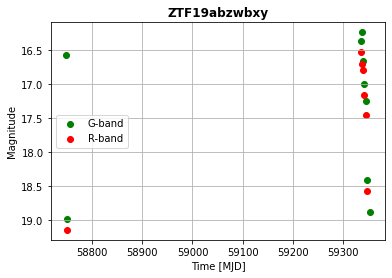

Importing lightcurve and metadata for source  ZTF18abtuzsb


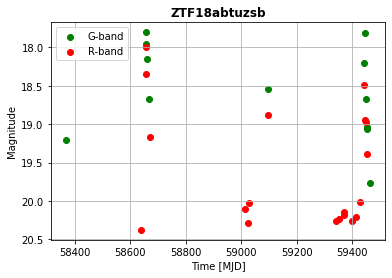

Importing lightcurve and metadata for source  ZTF18abklbam


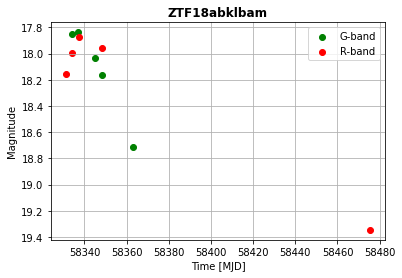

Importing lightcurve and metadata for source  ZTF18abmdpwe


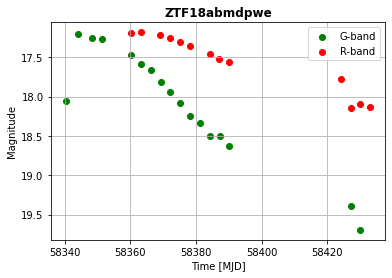

Importing lightcurve and metadata for source  ZTF18abqbuaj


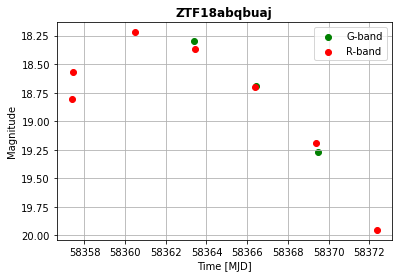

Data Dimensions :  (10, 4)
Features :  Index(['mjd_g', 'magpsf_g', 'mjd_r', 'magpsf_r'], dtype='object')


In [8]:
sources = list(alerce_found['oid'])

for i in range(5):
    data, metadata = alerce_retrieval(sources[i])
    lightcurve_plot(data, sources[i])

print('Data Dimensions : ', data.shape)
print('Features : ', data.columns)

## Class Query

For classification, we will need as large a dataset as possible. We can query ALeRCE to obtain the source IDs for a given class of transients. This output can then be used to pull whatever information we need (such as lightcurves). Below we perform a class query for SN Ia transients as an example.  

 Number of SNIa sources :  7999 
Importing lightcurve and metadata for source  ZTF18abklbam


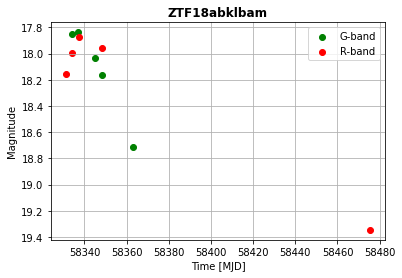

In [9]:
SNIa_oid = alerce_class_query(class_type='SNIa', num_detections=[10, 200], num_sources=10000)

SNIa_test_lc, SNIa_metadata = alerce_retrieval('ZTF18abklbam')

lightcurve_plot(SNIa_test_lc, 'ZTF18abklbam')

In [10]:
classes_alerce = ['SNIa', 'SNIbc', 'SNII']

In [11]:
dataset, mjd, labels = dataset_gen(classes_alerce)

 Number of SNIa sources :  7999 
Importing lightcurve and metadata for source  ZTF21abnvsic
Querying TNS for ZTF21abnvsic name and class verification...
Empty DataFrame
Columns: [objid, name_prefix, name, ra, declination, redshift, typeid, type, reporting_groupid, reporting_group, source_groupid, source_group, discoverydate, discoverymag, discmagfilter, filter, reporters, time_received, internal_names, creationdate, lastmodified]
Index: []

[0 rows x 21 columns]
TNS Class :  Series([], Name: type, dtype: object)
Importing lightcurve and metadata for source  ZTF21aavqphe
Querying TNS for ZTF21aavqphe name and class verification...
Empty DataFrame
Columns: [objid, name_prefix, name, ra, declination, redshift, typeid, type, reporting_groupid, reporting_group, source_groupid, source_group, discoverydate, discoverymag, discmagfilter, filter, reporters, time_received, internal_names, creationdate, lastmodified]
Index: []

[0 rows x 21 columns]
TNS Class :  Series([], Name: type, dtype: objec

#### Previous Problems
1. We encounter objects with labels null in TNS, corresponding to objects that do not have a class. These would probably have to be sorted out. We can use them as a test set if we want, to see what we predict for these objects.
2. After a few iterations, we do not get any output from TNS, we need to figure out how to solve this problem and still generate the dataset. 

#### Current Problems
1. We cannot generate a complete dataset without interpolating the lightcurves so that they have same dimensions. How do we wish to do this?
2. We need to define the project scope clearly. Should we focus on a classifier (RNN / CNN) solely, or should we work on building a dataset of high quality, that could possibly be used by David in his thesis afterwards. This would involve looking at VAE and CVAE to generate an exhaustive dataset that could then at another time be fed to a classifier for classification.

In [12]:
def filtering(dataset, mjd, labels):
    
    idx = np.array([])
    
    # Removing sources that do not have a class in TNS
    for i in range(labels.shape[0]):
        if labels.iloc[i, 'Class'] == None:
            idx = np.append(idx, i)
    
    dataset.drop(labels=idx, axis=0)
    mjd.drop(labels=idx, axis=0)
    labels.drop(labels=idx, axis=0)
    
    return dataset, mjd, labels

def label_encoding(labels):
    
    num_classes = labels.shape[1]
    labels_encoded = np.zeros(labels.shape)
    
    return labels_encoded

def interpolate(lightcurve):
    
    return lightcurve

#### Modelling Considerations
1. RNN : must be bi-directional as temporal dependence between points before and after the point considered
2. RNN : we can feed it the filter-ID as an additonal parameter, which we can't really do for CNN
3. CNN : we have a problem with giving it the filter-ID. Maybe use a FFNN to combine information about filter ID and output of CNN in a combined model, but this may not be efficient. Another alternative is to train a model that has to CNN's, one for each filter ID and then combine the information for a final prediction. The only problem we might encounter is that of ties, so not optimal either. 
4. TRADE-OFF : In the RNN, we can provide the algorithm with filter ID information. This we cannot do for the CNN. On the other hand, the CNN can look at the two time series at the same time, and relate them. There is thus a trade-off between filter ID information and comparison of both band lightcurves. 
5. BNN : Does not overfit much even on small datasets. May be of interest.

In [1]:
def TNS_get_class(object_id, TNS_objects):
    
    print('Querying TNS for', object_id,'name and class verification...') 
    
    TNS_ZTFobjects = TNS_objects['internal_names']
    TNS_objects = TNS_objects.loc[TNS_ZTFobjects == object_id]
    
    TNS_class = TNS_objects['type']
    TNS_class_id = TNS_objects['typeid']
    
    print('TNS Class : ', TNS_class)
        
    return TNS_class, TNS_class_id, TNS_objects, TNS_ZTFobjects

In [19]:
TNS_objects = pd.read_csv('tns_public_objects.csv', skiprows=1)
object_id = 'ZTF21abgyxuo'

In [20]:
TNS_objects['internal_names'][10000]

'ATLAS21rpd, ZTF21abgyxuo'

In [37]:
for i in range(len(TNS_objects['internal_names'])):
    print(i)
    if np.isnan(TNS_objects['internal_names'][i]) == True:
        continue
    else:
        if object_id in TNS_objects['internal_names'][i]:
            print(i)

0


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [38]:
np.isnan(TNS_objects['internal_names'][0])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''